In [24]:
import pandas as pd
import geopandas as gpd
import tensorflow as tf
# import teller as tr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
import missingno as msno
# import pyarrow as pa
# import pyarrow.parquet as pq
import numpy as np

In [22]:
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:

path = './nowa_gwiazdka.geojson'
df_p = gpd.read_file(path)


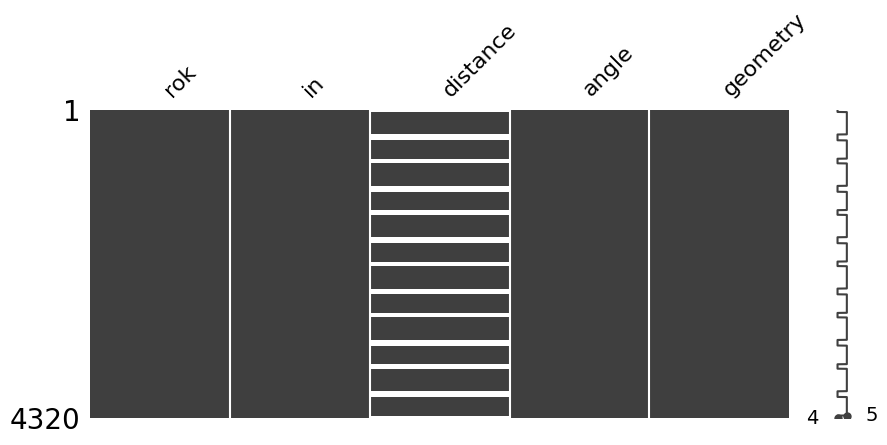

In [34]:
msno.matrix(df_p, figsize=(10,4)) # test pustych wierszy
df_p =df_p.fillna(0) # wypełnianie Nan zerami


In [35]:
df_p.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rok,4320.0,2016.833333,3.891323,2011.0,2013.000000,2017.500000,2020.000000,2022.00000
distance,4320.0,155.815937,94.355739,0.0,114.945461,168.992062,236.042924,299.73138
angle,4320.0,179.500000,103.934678,0.0,89.750000,179.500000,269.250000,359.00000


In [36]:
df_p.head()

,rok,in,distance,angle,geometry
0,2011,True,0.0,0,"LINESTRING (7527541.11000 5863838.87000, 75275..."
1,2011,True,0.0,1,"LINESTRING (7527541.11000 5863838.87000, 75275..."
2,2011,True,0.0,2,"LINESTRING (7527541.11000 5863838.87000, 75275..."
3,2011,True,0.0,3,"LINESTRING (7527541.11000 5863838.87000, 75275..."
4,2011,True,0.0,4,"LINESTRING (7527541.11000 5863838.87000, 75275..."


In [37]:
df_p.shape


(4320, 5)

In [41]:
#normalizacja i podzial na dane wejsciowe i wyjsciowe
X = df_p[["rok", 'in', 'angle']]
X = MinMaxScaler().fit_transform(X)
y = df_p['distance']
X.shape, y.shape

((4320, 3), (4320,))

In [42]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     # random_state=42,
                                                     test_size=.4)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2592, 3), (1728, 3), (2592,), (1728,))

# MODEL

In [44]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate,Dropout,CategoryEncoding, Embedding, Flatten,Conv2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.random import set_seed #ustawiam ziarno pseudolosowości
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime as dt
import os

In [45]:
N_TRAIN = int(1e4)
BATCH_SIZE = 16
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

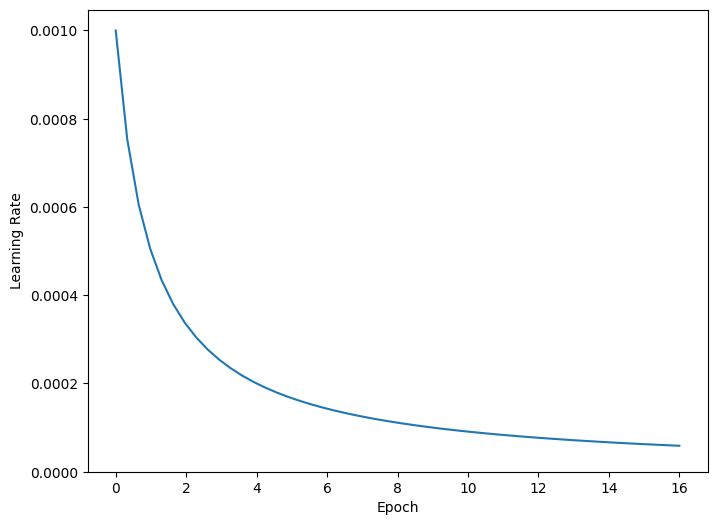

In [46]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [48]:
from keras import regularizers


def create_ANN():
    set_seed(0)
    model = Sequential()
    model.add(
        Dense(3, activation='relu',
              kernel_regularizer=regularizers.l2(0.001), #opcja
              kernel_initializer='he_uniform')
    )
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    model.add(
        Dense(1, activation='relu',
              kernel_regularizer=regularizers.l2(0.001))# opcja
    )

    model.compile(
        loss='mae',
        optimizer=get_optimizer(),
        metrics=['mae','mse'])

    return model

In [49]:
_filepath = 'checkpoint/ann-{epoch:02d}-{loss:.3f}.h5' # for filepath
checkpoint = ModelCheckpoint(monitor='loss', filepath='checkpoint/_best-ann.h5', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='loss', patience=3, min_delta=0.01, verbose=1)
tb = TensorBoard(log_dir='logs/'+dt.now().strftime("%Y%m%d-%H%M%S")) # logi tensor board

In [50]:
model = create_ANN()

result = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    validation_split=.3,
    callbacks=[checkpoint,es,tb],
    verbose=0,
)


Epoch 1: loss improved from inf to 155.28040, saving model to checkpoint\_best-ann.h5


C:\Users\patry\Desktop\ai_river_project\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 155.28040 to 155.00467, saving model to checkpoint\_best-ann.h5

Epoch 3: loss improved from 155.00467 to 154.62675, saving model to checkpoint\_best-ann.h5

Epoch 4: loss improved from 154.62675 to 154.30324, saving model to checkpoint\_best-ann.h5

Epoch 5: loss improved from 154.30324 to 153.96297, saving model to checkpoint\_best-ann.h5

Epoch 6: loss improved from 153.96297 to 153.66121, saving model to checkpoint\_best-ann.h5

Epoch 7: loss improved from 153.66121 to 153.25206, saving model to checkpoint\_best-ann.h5

Epoch 8: loss improved from 153.25206 to 152.76028, saving model to checkpoint\_best-ann.h5

Epoch 9: loss improved from 152.76028 to 152.62381, saving model to checkpoint\_best-ann.h5

Epoch 10: loss improved from 152.62381 to 152.44949, saving model to checkpoint\_best-ann.h5

Epoch 11: loss improved from 152.44949 to 151.83536, saving model to checkpoint\_best-ann.h5

Epoch 12: loss improved from 151.83536 to 151.62407, saving model t

In [51]:
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [52]:
# evaluate the keras model
loss,  mae , mse = model.evaluate(X_test, y_test)
print(f'loss:{loss}, \nmse: {mse}')

54/54 [==============================] - 0s 3ms/step - loss: 143.7540 - mae: 143.7206 - mse: 27574.1992
loss:143.7539520263672, 
mse: 27574.19921875


Text(0.5, 0, 'Epoka')

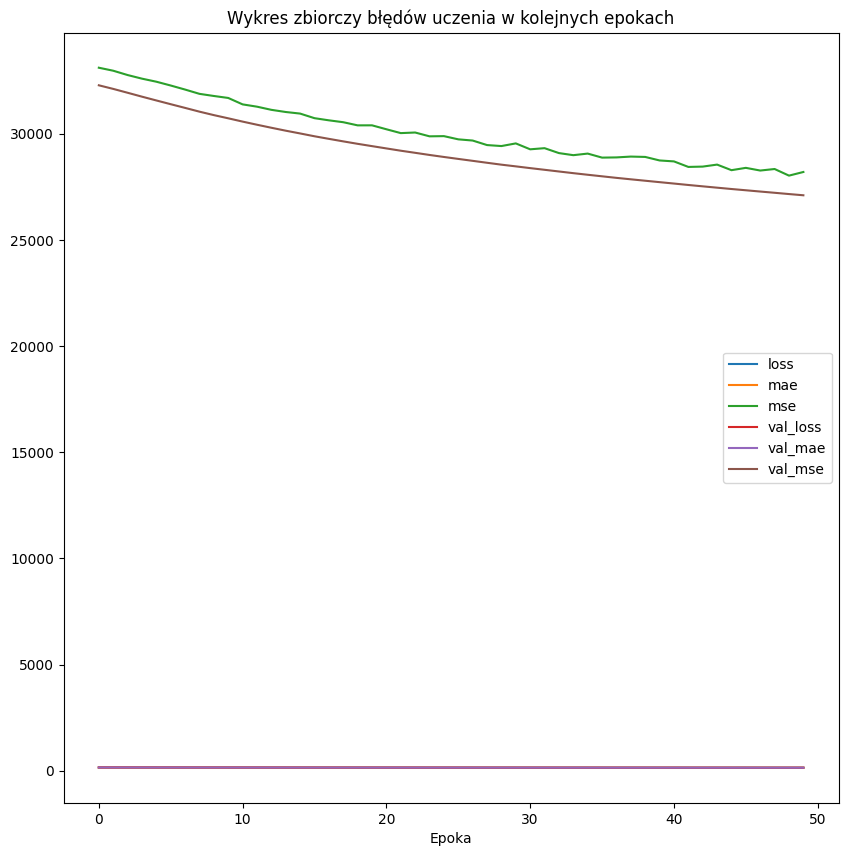

In [53]:
df_results = pd.DataFrame(result.history)
df_results.plot(figsize=(10,10))
plt.title('Wykres zbiorczy błędów uczenia w kolejnych epokach')
plt.xlabel('Epoka')

In [54]:
df_results

,loss,mae,mse,val_loss,val_mae,val_mse
0,155.280396,155.271606,33113.074219,155.214676,155.205597,32285.357422
1,155.004669,154.995239,32972.007812,154.864655,154.854828,32115.888672
2,154.626755,154.616577,32768.695312,154.484848,154.474228,31934.097656
3,154.303238,154.292221,32598.035156,154.096786,154.085388,31749.812500
4,153.962967,153.951157,32454.261719,153.717468,153.705215,31571.218750
5,153.661209,153.648590,32274.910156,153.339752,153.326736,31394.779297
6,153.252060,153.238647,32084.308594,152.964249,152.950439,31220.644531
7,152.760284,152.746078,31882.523438,152.580124,152.565475,31043.455078
8,152.623810,152.608795,31781.873047,152.224701,152.209244,30880.806641
9,152.449493,152.433777,31688.988281,151.894928,151.878799,30730.423828


In [55]:
y_predicted = model.predict(X_test)

54/54 [==============================] - 0s 3ms/step


In [57]:
df__a = pd.DataFrame(y_test)
df__a['y_predicted']=y_predicted
df__a['diff']=df__a.y_predicted-df__a.distance
df__a['abs_diff'] = abs(df__a['diff'])
df__a['diff_pow']=df__a['diff']*df__a['diff']
df__a.tail()

,distance,y_predicted,diff,abs_diff,diff_pow
1407,0.000000,17.617619,17.617619,17.617619,310.380484
72,91.193645,13.127579,-78.066066,78.066066,6094.310674
1402,282.029354,17.489883,-264.539471,264.539471,69981.131625
4236,205.128883,23.872643,-181.256241,181.256241,32853.824824
2905,0.000000,19.521873,19.521873,19.521873,381.103544


In [58]:
import math
mean_ref = df__a['distance'].describe()[1]
bias = df__a['diff'].describe()[1]
mae =df__a['abs_diff'].describe()[1]
RMSE = math.sqrt(df__a['diff_pow'].sum()/df__a.shape[0])
print(
    f'mean_ref: {mean_ref},'
    f'\nbias: {bias}, \nbias_%: {bias/mean_ref*100}, '
    f'\nmae: {mae}, \nmae_%: {mae/mean_ref*100}, '
    f'\nRMSE: {RMSE} \nRMSE %: {RMSE/mean_ref*100}'
)

mean_ref: 155.6088219186136,
bias: -136.77996950435661, 
bias_%: -87.89988113649184, 
mae: 143.72062952241654, 
mae_%: 92.36020667104928, 
RMSE: 166.0548143872092 
RMSE %: 106.7129821688767


C:\Users\patry\AppData\Local\Temp\ipykernel_4936\758387956.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_ref = df__a['distance'].describe()[1]
C:\Users\patry\AppData\Local\Temp\ipykernel_4936\758387956.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bias = df__a['diff'].describe()[1]
C:\Users\patry\AppData\Local\Temp\ipykernel_4936\758387956.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mae =df__a['abs_diff'].de

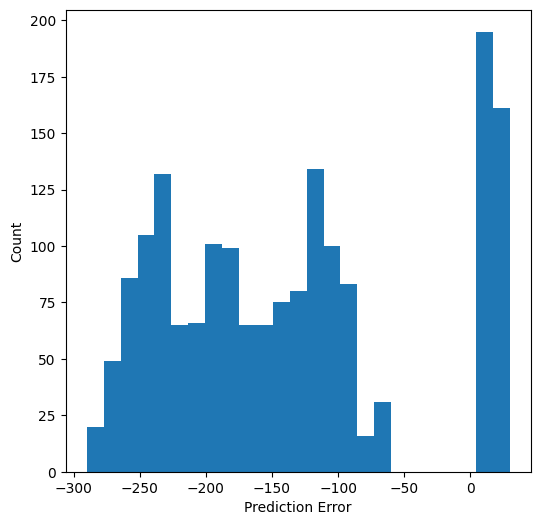

In [59]:
# rozkład błedów
error = df__a.y_predicted-df__a.distance
plt.figure(figsize = (6,6))
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

<Figure size 800x800 with 0 Axes>

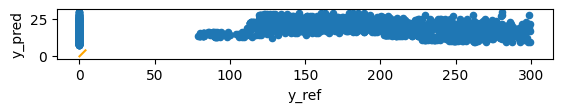

In [61]:
plt.figure(figsize = (8,8))
df__a.plot.scatter(y='y_predicted', x='distance')
plt.plot(range(5), color='orange')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('y_ref')
plt.ylabel('y_pred')
plt.draw()